# Predicting Loan Defaults

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.style.use('classic')
sns.set_style("dark")

%matplotlib inline 

## Part 1: Exploring Loan Data

In [2]:
cols = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
df = pd.read_csv('loan.csv', usecols=cols, parse_dates=['issue_d'])

In [3]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,2011-12-01,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,2011-12-01,Current,17.94,27783.0,3242.170000


In [4]:
#identify missing values
df.isnull().sum()

#inspect the few null rows of data
df[df['annual_inc'].isnull()]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,NaN,2007-07-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,NaN,2007-06-01,Does not meet the credit policy. Status:Fully ...,4.0,0.0,7373.83


Since there are only a missing rows of null data, it should be ok removing these from the dataset knowing it shouldn't affect our overall analysis

In [5]:
#remove missing values
df.dropna(inplace=True)

#verify missing values are removed
df.isnull().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     0
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887375 entries, 0 to 887378
Data columns (total 11 columns):
loan_amnt      887375 non-null float64
funded_amnt    887375 non-null float64
term           887375 non-null object
int_rate       887375 non-null float64
grade          887375 non-null object
annual_inc     887375 non-null float64
issue_d        887375 non-null datetime64[ns]
loan_status    887375 non-null object
dti            887375 non-null float64
revol_bal      887375 non-null float64
total_pymnt    887375 non-null float64
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 81.2+ MB


In [7]:
#examine the object fields
df['term'].value_counts()
df['grade'].value_counts()
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1984
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [8]:
#remove leading whitespace from term column
df['term'] = df['term'].str[1:]

#remove extraneous text from loan status
df['loan_status'] = df['loan_status'].str.replace('Does not meet the credit policy. Status:','')

#get loan issuance year for ease of analysis
df['issue_y'] = df['issue_d'].dt.year

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000254433F5240>,
      dtype=object)

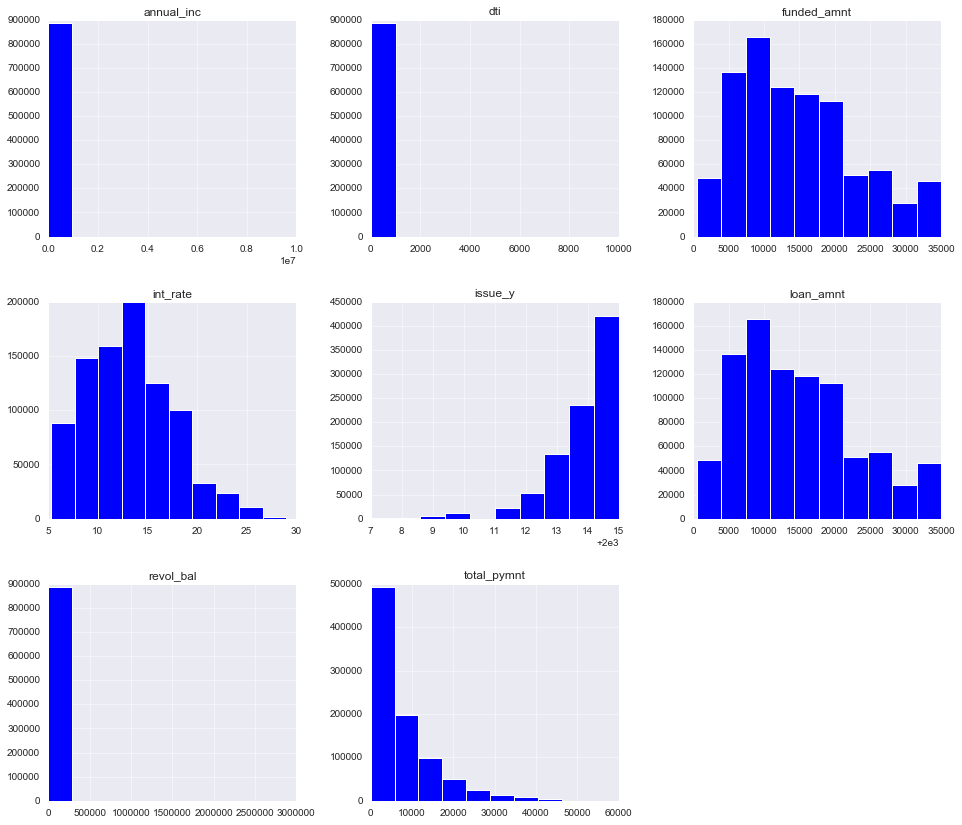

In [9]:
plt.rcParams['figure.figsize'] = (16, 14)
df.hist()

Looking at the distribution graphs, a few variables seem to have some outliers on the high end (annual income, dt, and revolving balance).

In order to deal with these outliers, we exclude any instances of data that have values higher than 3 standard deviations of the mean (which excludes data above the 99th percentile). This is done so that outliers do not skew the predictive model later.

In [10]:
drop_ind = df[(stats.zscore(df['annual_inc']) > 3) | (stats.zscore(df['dti']) > 3) | (stats.zscore(df['revol_bal']) > 3)].index
df.drop(drop_ind, inplace=True)

print(len(drop_ind), 'rows removed')

16433 rows removed


In [11]:
df.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,issue_y
count,870942.000000,870942.000000,870942.000000,870942.000000,870942.000000,870942.000000,870942.000000,870942.000000
mean,14588.335963,14575.340235,13.267543,71486.055110,18.163082,15185.597307,7498.998351,2014.019219
std,8324.876280,8319.332864,4.376157,37423.741829,8.283093,12572.730501,7789.376266,1.260531
min,500.000000,500.000000,5.320000,1896.000000,0.000000,0.000000,0.000000,2007.000000
25%,8000.000000,8000.000000,9.990000,45000.000000,11.960000,6371.000000,1906.352500,2013.000000
50%,12800.000000,12800.000000,12.990000,63000.000000,17.690000,11682.000000,4868.805000,2014.000000
75%,20000.000000,20000.000000,16.200000,89000.000000,23.960000,20239.000000,10558.307500,2015.000000
max,35000.000000,35000.000000,28.990000,269000.000000,69.350000,84198.000000,57777.579870,2015.000000


Now the distributions across each continuous variable look more reasonable.

As for the categorical variables, the below visualization takes a look at interest rates across different loan grades. We can see that lower grades tend to have higher interest rates, which intuitively makes sense.

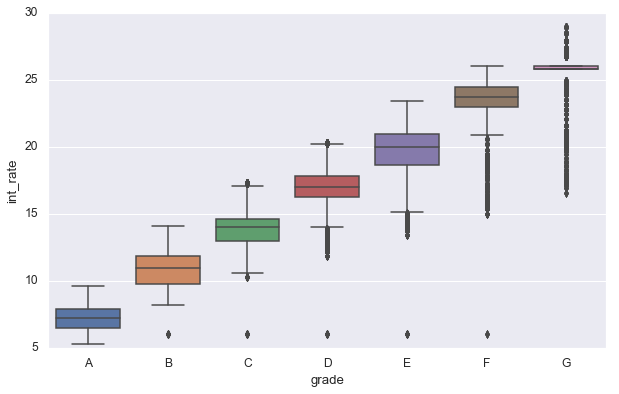

In [12]:
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(font_scale=1.1)
sns.boxplot(x='grade', y='int_rate', data=df, order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

I also take an initial look at distribution across loan status to get a sense of overall breakdown.

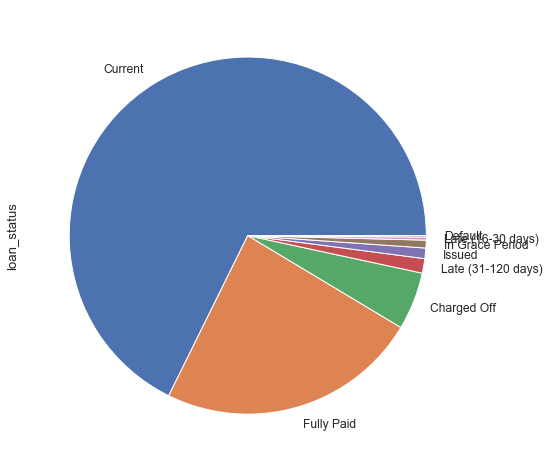

In [13]:
plt.rcParams['figure.figsize'] = (8, 8)
df['loan_status'].value_counts().plot.pie()

## Part 2: Business Analysis

#### Percent of 36 month loans that have been fully paid

Since we only want to examine 36 month loans with at least 3 years worth of data, we will create a subset of the original data containing only loans with a term of 36, and issue year in 2012 or earlier.

In [14]:
df_sub = df[(df['term'] == '36 months') & (df['issue_y'] <= 2012)].copy()
df_sub.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,issue_y
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011


In [15]:
df_sub['loan_status'].value_counts(normalize=True)

Fully Paid            0.868535
Charged Off           0.129613
Late (31-120 days)    0.001082
Current               0.000446
Default               0.000162
Late (16-30 days)     0.000081
In Grace Period       0.000081
Name: loan_status, dtype: float64

About 87% of these loans have been fully paid.

In [16]:
df_sub['is_default'] = df_sub['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [17]:
default_by_cohort = pd.pivot_table(df_sub,
                                   index=df['issue_y'], columns=df['grade'],values='is_default')

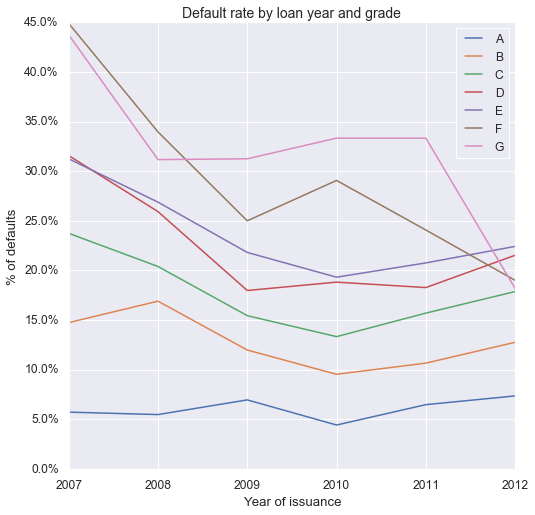

In [18]:
ax = sns.lineplot(data=default_by_cohort, dashes=False)
ax.set_title('Default rate by loan year and grade', fontsize=14)

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(font_scale=1.1)
plt.xlabel('Year of issuance')
plt.ylabel('% of defaults')

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.ticklabel_format(useOffset=False, style='plain',axis='x')

The 2007 grade G loans have the highest rate of default. Overall, the loans in year 2007 have the highest rate of default, which makes sense leading into the 2008 financial crisis.

In [19]:
df_sub['annual_return'] = np.power((df_sub['total_pymnt'] / df_sub['funded_amnt']), (1/3)) - 1
df_sub.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,issue_y,is_default,annual_return
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011,0,0.054393
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011,0,0.077654
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011,0,0.069297
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011,0,0.040435
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011,0,0.094940


In [20]:
returns_by_cohort = pd.pivot_table(df_sub, index=df['issue_d'].dt.year, columns=df['grade'],values='annual_return')

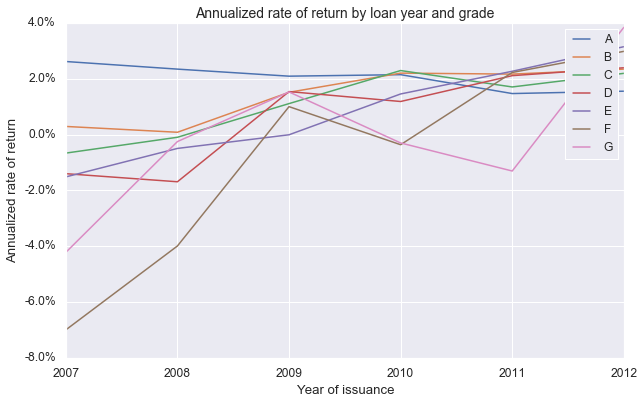

In [21]:
ax = sns.lineplot(data=returns_by_cohort, dashes=False)
ax.set_title('Annualized rate of return by loan year and grade', fontsize=14)

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(font_scale=1.1)

plt.xlabel('Year of issuance')
plt.ylabel('Annualized rate of return')

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.ticklabel_format(useOffset=False, style='plain',axis='x')

As expected, grade A loans have the highest rates of return on average, but have dropped slightly across 2007-2012. Contrarily, the return on lower grade loans has climbed pretty steadily over this period (from being negative in 2007).

## Part 3: Logistic Regression

For our classification model, we are trying to predict that a loan defaults more accurately than the null hypothesis, which would be 87% accurate if it just assigned 'no default' to each loan. In terms of predictive accuracy, I care the most about maximizing recall (ie rate of accurately identifying loans that truly defaulted), because this would result in the least amount of exposure to risk of investing in bad debt.

In order to understand which continuous variables in the dataset make most sense to include in logistic regression, I look at a pairplot to understand the correlations among these variables and their impact on chance of default.

C:\Users\Minnie\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


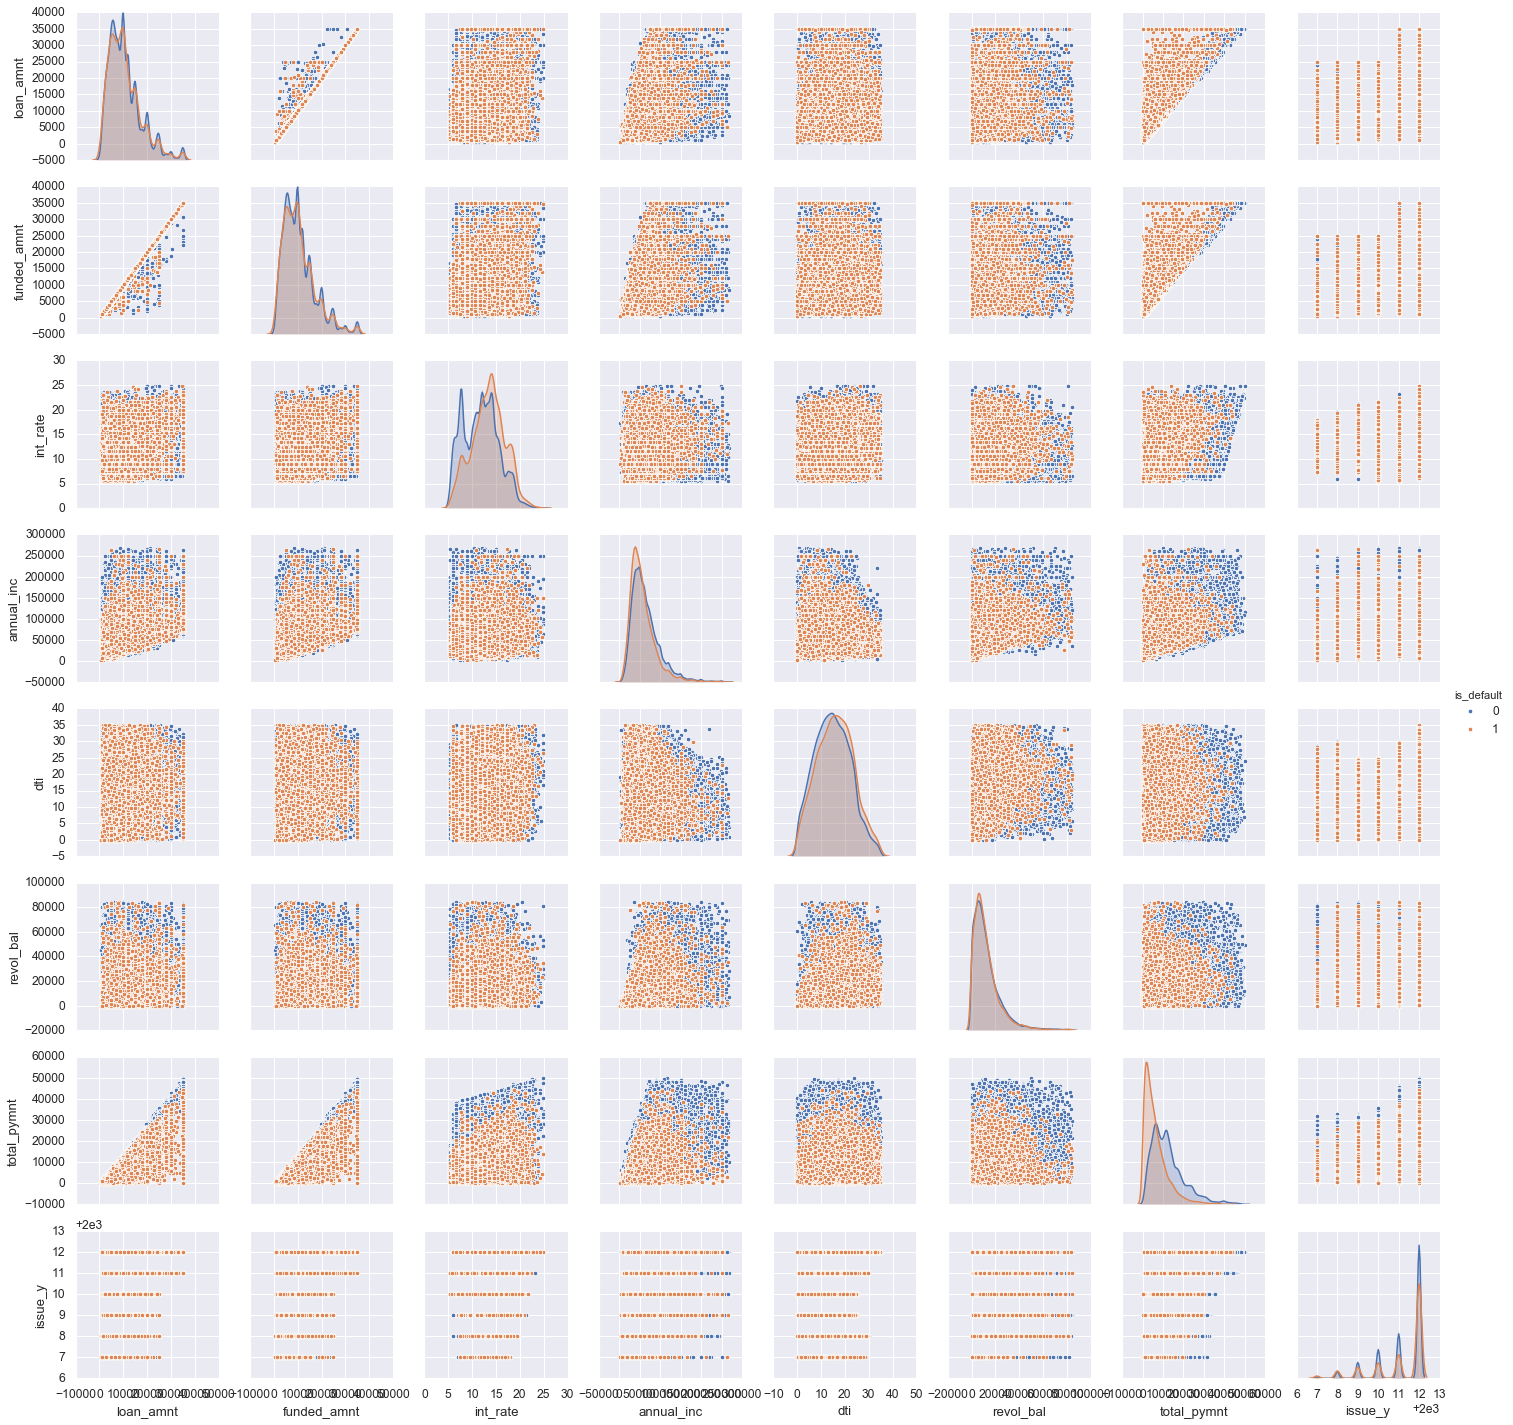

In [22]:
cont_vars = ['loan_amnt','funded_amnt','int_rate','annual_inc','dti','revol_bal','total_pymnt','issue_y']
sns.pairplot(df_sub, vars=cont_vars, hue='is_default')

From the pairplot, it seems that the following variables show the greatest distinction between default and not.

- interest rate (loan issuers should generally require a higher interest rate for loans that have a higher chance of defaulting based on their assessments)
- debt to income ratio (higher debt to income ratio is also a sign of higher default risk)

Although higher total payment on the loan also seems to be linked to fewer default cases, this information doesn't exist at the time of loan origination, so we would not be able to use it as a predictor.

Based on earlier analysis, although loan grade seems to impact the chance of default (see part 2), loan grade also seems strongly correlated with interest rate (see part 1). Since logistic regression does well when input variables are not strongly correlated with each other, I choose not to include loan grade in the predictive model.

In [23]:
df_sub.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,issue_y,is_default,annual_return
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011,0,0.054393
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011,0,0.077654
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011,0,0.069297
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011,0,0.040435
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011,0,0.094940


In [24]:
logreg = LogisticRegression(solver='liblinear')

feature_cols = ['int_rate','dti']
X = df_sub[feature_cols]
y = df_sub['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

Overall model accuracy: 87%
Recall score: 0%


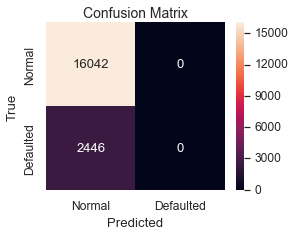

In [25]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams['figure.figsize'] = (4, 3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Normal', 'Defaulted'])
ax.yaxis.set_ticklabels(['Normal', 'Defaulted'])

print(f'Overall model accuracy: {logreg.score(X_test, y_test):.0%}')
print(f'Recall score: {metrics.recall_score(y_test, y_pred):.0%}')

These results show that our logistic regression model is not really working properly since it's just predicting the null hypothesis for all scenarios, thereby getting the same accuracy score.

Below are a few ways I tried to improve the model.

#### 1) GridSearch through different model parameters

In [26]:
parameters = {
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

clf = GridSearchCV(logreg, parameters, cv=5, scoring='recall', verbose=0)

In [27]:
%%time
clf.fit(X_train, y_train)

Wall time: 17.8 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [28]:
print(clf.best_params_)
print(clf.best_score_)

{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1'}
0.8312241567965315


Overall model accuracy: 74%
Recall score: 74%


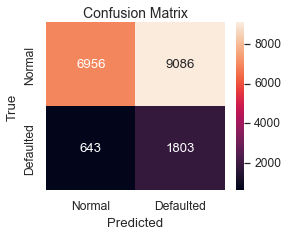

In [29]:
y_pred = clf.predict(X_test)

cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams['figure.figsize'] = (4, 3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Normal', 'Defaulted'])
ax.yaxis.set_ticklabels(['Normal', 'Defaulted'])

print(f'Overall model accuracy: {clf.score(X_test, y_test):.0%}')
print(f'Recall score: {metrics.recall_score(y_test, y_pred):.0%}')

Although overall accuracy of the updated model decreased, the rate of predicting defaulted loans went from 0% to 74% accuracy.

#### 2) Feature engineering

Although our pairplot above shows that loan amount (applied) and funded amount do not have much impact on default as independent variables, but I'm interested in seeing whether the ratio of funded-to-loan amount is any indication of the assessor's risk measure. Therefore I will add this into the model and see if results improve.

In [30]:
df_sub['funded-to-loan-ratio'] = df_sub['funded_amnt'] / df_sub['loan_amnt']
df_sub.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,issue_y,is_default,annual_return,funded-to-loan-ratio
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,2011,0,0.054393,1.0
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,2011,0,0.077654,1.0
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,2011,0,0.069297,1.0
5,5000.0,5000.0,36 months,7.90,A,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,2011,0,0.040435,1.0
7,3000.0,3000.0,36 months,18.64,E,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,2011,0,0.094940,1.0


In [31]:
logreg = LogisticRegression(solver='liblinear')

feature_cols = ['int_rate','dti','funded-to-loan-ratio']
X = df_sub[feature_cols]
y = df_sub['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

Overall model accuracy: 87%
Recall score: 0%


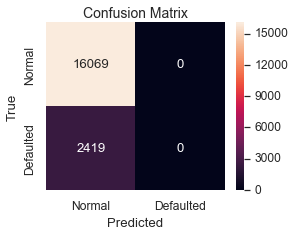

In [32]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams['figure.figsize'] = (4, 3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Normal', 'Defaulted'])
ax.yaxis.set_ticklabels(['Normal', 'Defaulted'])

print(f'Overall model accuracy: {logreg.score(X_test, y_test):.0%}')
print(f'Recall score: {metrics.recall_score(y_test, y_pred):.0%}')

Adding this feature did not change the accuracy or recall score, so it doesn't seem like a good additional predictor variable.

#### 3) Start with more features and use feature selection methods to filter the most impactful predictors

Although I originally narrowed down the set of predictor variables to only ones I felt would be meaningful, I will also try to run the model on broader set of features and use a recursive feature elimination algorithm to see which ones are impactful.

Note: I do not include revolving balance, total payment, and annual return because these are variables not known at the time of loan issuance and therefore cannot be used for prediction purposes.

In [33]:
#prepare categorical variables for model
df_sub = pd.get_dummies(df_sub, columns=['grade', 'issue_y'], drop_first=True)
df_sub.head()

,loan_amnt,funded_amnt,term,int_rate,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt,...,grade_C,grade_D,grade_E,grade_F,grade_G,issue_y_2008,issue_y_2009,issue_y_2010,issue_y_2011,issue_y_2012
0,5000.0,5000.0,36 months,10.65,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414,...,0,0,0,0,0,0,0,0,1,0
2,2400.0,2400.0,36 months,15.96,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644,...,1,0,0,0,0,0,0,0,1,0
3,10000.0,10000.0,36 months,13.49,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212,...,1,0,0,0,0,0,0,0,1,0
5,5000.0,5000.0,36 months,7.90,36000.0,2011-12-01,Fully Paid,11.20,7963.0,5631.377753,...,0,0,0,0,0,0,0,0,1,0
7,3000.0,3000.0,36 months,18.64,48000.0,2011-12-01,Fully Paid,5.35,8221.0,3938.144334,...,0,0,1,0,0,0,0,0,1,0


In [35]:
#set new feature cols to include all information at our disposal
feature_cols = df_sub.columns.drop(['term','issue_d', 'loan_status', 'revol_bal', 'total_pymnt', 'is_default', 'annual_return'])
feature_cols

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti',
       'funded-to-loan-ratio', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'issue_y_2008', 'issue_y_2009', 'issue_y_2010',
       'issue_y_2011', 'issue_y_2012'],
      dtype='object')

In [36]:
logreg = LogisticRegression(solver='liblinear')
rfe = RFE(logreg, 6)

X = df_sub[feature_cols]
y = df_sub['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

fit = rfe.fit(X_train,y_train)

y_pred = rfe.predict(X_test)

In [37]:
features_selected = pd.DataFrame(feature_cols, index = fit.ranking_, columns=['feature_name'])
features_selected.sort_index()

,feature_name
1,grade_D
1,grade_G
1,grade_F
1,grade_B
1,grade_C
1,grade_E
2,funded-to-loan-ratio
3,issue_y_2010
4,issue_y_2011
5,issue_y_2009


This feature selection method results in loan grade having the highest impact. Below is the performance of the refitted model with only these selected features.

Overall model accuracy: 87%
Recall score: 0%


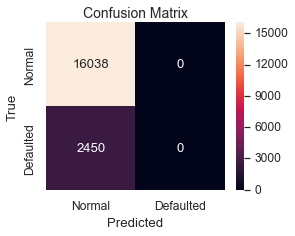

In [38]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams['figure.figsize'] = (4, 3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Normal', 'Defaulted'])
ax.yaxis.set_ticklabels(['Normal', 'Defaulted'])

print(f'Overall model accuracy: {fit.score(X_test, y_test):.0%}')
print(f'Recall score: {metrics.recall_score(y_test, y_pred):.0%}')

Based on accuracy and recall, this feature-enhanced model is still not performing much differently from the original.

I will use these selected features to run through the gridsearch again and see if predictability is improved at all.

In [39]:
logreg = LogisticRegression(solver='liblinear')

feature_cols = ['grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
X = df_sub[feature_cols]
y = df_sub['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

In [40]:
parameters = {
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

clf = GridSearchCV(logreg, parameters, cv=5, scoring='recall', verbose=0)

In [41]:
%%time
clf.fit(X_train, y_train)

Wall time: 8.55 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

Overall model accuracy: 54%
Recall score: 54%


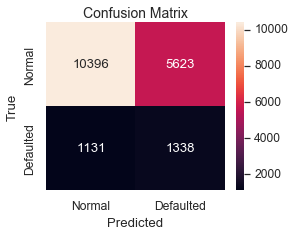

In [43]:
y_pred = clf.predict(X_test)

cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams['figure.figsize'] = (4, 3)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('True')
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Normal', 'Defaulted'])
ax.yaxis.set_ticklabels(['Normal', 'Defaulted'])

print(f'Overall model accuracy: {clf.score(X_test, y_test):.0%}')
print(f'Recall score: {metrics.recall_score(y_test, y_pred):.0%}')

This feature selected model actually has a much lower accuracy and recall compared to my original model with manual feature selection.

## Conclusion

Ultimately, it seems that using grid search to identify the best logistic regression parameters on my on manually chosen features model resulted in the best predictability of loan defaults. Although 74% accuracy isn't something to jump for joy over, it is definitely better than not having any predictability for which loans would default.